# Поиск по изображениям

**Содержание:**  
1. [Импорт данных и общая информация](#section_1)  
 1.1. [Импорт библиотек](#section_1_1)  
 1.2. [Импорт данных](#section_1_2)  
 1.3. [Общая информация](#section_1_3)  
 

2. [Исследовательский анализ данных](#section_2)  
      
3. [Проверка данных](#section_3)  
 3.1. [Обработка запрещенного контента](#section_3_1)  
 3.2. [Оценки соответствия описания изображению](#section_3_2)   


4. [Вектаризация изображений](#section_4)  

5. [Векторизация текстов](#section_5)  

6. [Объединение векторов](#section_6)  

7. [Обучение модели предсказания соответствия](#section_7)  
 7.1. [LinearRegression](#section_7_1)  
 7.2. [NeuralNetwork](#section_7_2)   
 7.3. [Сводная таблица](#section_7_3)  

8. [Тестирование модели](#section_8)  

9. [Общий вывод](#section_9)  

**Заказчик исследования:** фотохостинге для профессиональных фотографов «Со Смыслом» ("With Sense").  

**Цель исследования:** построить модель подбора фотографий по описанию.  

**Инструменты:** для реализации проекта использованы модели LinearRegression, полносвязная нейронная сеть, BERT, nltk.  

**Метрики:**  
Функция потерь: MSE;  
Метрика качества: MAE;  

**Особенности проекта:**   
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.  
При попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:  
"This image is unavailable in your country in compliance with local laws."  

**Исходные данные:**  
Исходные данные представлены в датасетах:
1. test_images.csv (тестовые изображения).  
 - image: имя файла изображения.  
2. test_queries.csv (описания к тестовым изображениям).
 - query_id: идентификатор изображения;
 - query_text: описание изображения;
 - image: имя файла изображения.
3. train_dataset.csv (данные по обучающей выборке изображений).
 - query_id: идентификатор изображения;
 - query_text: описание изображения;
 - image: имя файла изображения.
4. CrowdAnnotations.tsv (данные по соответствию изображения и описания, полученные с помощью краудсорсинга)
 - query_id: идентификатор изображения;
 - image: имя файла изображения;
 - fraction: доля людей, подтвердивших, что описание соответствует изображению;
 - pros: количество человек, подтвердивших, что описание соответствует изображению;
 - cons: количество человек, подтвердивших, что описание не соответствует изображению.
5. ExpertAnnotations.tsv (данные по соответствию изображения и описания, полученные в результате опроса экспертов).
 - query_id: идентификатор изображения;
 - image: имя файла изображения;
 - first_eval, second_eval, third_eval - оценки трех экспертов (от 1 до 4).

## Импорт данных и общая информация
<a id="section_1"></a>

### Импорт библиотек
<a id="section_1_1"></a>

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import swifter
import tensorflow as tf
import torch
import transformers as ppb

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from pathlib import Path
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
# from sklearn.utils import shuffle
import statistics as st
from stop_words import get_stop_words
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook

### Импорт данных
<a id="section_1_2"></a>

In [2]:
df_test_img = pd.read_csv('test_images.csv')
df_test_queries = pd.read_csv('test_queries.csv', sep='|', index_col=0)
df_train = pd.read_csv('train_dataset.csv')
df_crowd = pd.read_csv('CrowdAnnotations.tsv', sep='\t', names = ['image', 'query_id', 'fraction', 'pros', 'cons'])
df_expert = pd.read_csv('ExpertAnnotations.tsv', sep='\t', names = ['image', 'query_id', 'first_eval', 'second_eval', 'third_eval'])

### Общая информация
<a id="section_1_3"></a>

In [3]:
df_test_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


In [4]:
df_test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   fraction  47830 non-null  float64
 3   pros      47830 non-null  int64  
 4   cons      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [7]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        5822 non-null   object
 1   query_id     5822 non-null   object
 2   first_eval   5822 non-null   int64 
 3   second_eval  5822 non-null   int64 
 4   third_eval   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


Выводим по 5 случайных наблюдений каждого датафрейма:

In [8]:
print('Тестовые изображения (df_test_img)')
display(df_test_img.sample(n = 5, random_state = 0))
print('_'*50)
print()
print('Описания к тестовым изображениям (df_test_queries)')
display(df_test_queries.sample(n = 5, random_state = 0))
print('_'*50)
print()
print('Данные по обучающей выборке изображений (df_test_queries)')
display(df_train.sample(n = 5, random_state = 0))
print('_'*50)
print()
print('Данные по соответствию изображения и описания, полученные с помощью краудсорсинга (df_crowd)')
display(df_crowd.sample(n = 5, random_state = 0))
print('_'*50)
print()
print('Данные по соответствию изображения и описания, полученные в результате опроса экспертов (df_expert)')
display(df_crowd.sample(n = 5, random_state = 0))
print('_'*50)
print()

Тестовые изображения (df_test_img)


image
26   989754491_7e53fb4586.jpg
86  1745110280_0cbff5e273.jpg
2   3089107423_81a24eaf18.jpg
55  3211199368_ca78387f72.jpg
75  3601978895_9fec23ce0c.jpg

__________________________________________________

Описания к тестовым изображениям (df_test_queries)


query_id  \
90   2399219552_bbba0a9a59.jpg#0   
254  3163198309_bbfe504f0a.jpg#4   
283  3262849619_0bc4f88ef9.jpg#3   
445   572618443_647483ca82.jpg#0   
461   661749711_6f408dad62.jpg#1   

                                            query_text  \
90                            A boy plays basketball .   
254  There are several people watching a person in ...   
283  A brown and white dog walks in the snow with a...   
445    A man and two boys standing in spraying water .   
461  a small shaggy dog plays with a red ball on th...   

                         image  
90   2399219552_bbba0a9a59.jpg  
254  3163198309_bbfe504f0a.jpg  
283  3262849619_0bc4f88ef9.jpg  
445   572618443_647483ca82.jpg  
461   661749711_6f408dad62.jpg

__________________________________________________

Данные по обучающей выборке изображений (df_test_queries)


image                     query_id  \
840   3502993968_4ee36afb0e.jpg  3601843201_4809e66909.jpg#2   
3338  1982852140_56425fa7a2.jpg   106490881_5a2dd9b7bd.jpg#2   
2976  2675685200_0913d84d9b.jpg  2533642917_a5eace85e6.jpg#2   
5114  2644430445_47c985a2ee.jpg  3364861247_d590fa170d.jpg#2   
527    256085101_2c2617c5d0.jpg  3459156091_c1879ebe28.jpg#2   

                                             query_text  
840   A person wearing a red and white uniform is ra...  
3338  A young boy in swimming trunks is walking with...  
2976  a toddler wearing colorful shorts is standing ...  
5114  A woman in a pink sweater looks pensive next t...  
527   A picture of Albert Einstein on a white bear s...

__________________________________________________

Данные по соответствию изображения и описания, полученные с помощью краудсорсинга (df_crowd)


image                     query_id  fraction  pros  \
10656   241346508_0b3907a95b.jpg  2310126952_7dc86d88f6.jpg#2  0.000000     0   
25180  3123463486_f5b36a3624.jpg  2301525531_edde12d673.jpg#2  0.000000     0   
33254  3425835357_204e620a66.jpg  2788945468_74a9618cfa.jpg#2  0.000000     0   
28212  3224227640_31865b3651.jpg  3224227640_31865b3651.jpg#2  0.666667     2   
3437   1523984678_edd68464da.jpg  3467219837_7d62213dec.jpg#2  0.000000     0   

       cons  
10656     3  
25180     3  
33254     3  
28212     1  
3437      3

__________________________________________________

Данные по соответствию изображения и описания, полученные в результате опроса экспертов (df_expert)


image                     query_id  fraction  pros  \
10656   241346508_0b3907a95b.jpg  2310126952_7dc86d88f6.jpg#2  0.000000     0   
25180  3123463486_f5b36a3624.jpg  2301525531_edde12d673.jpg#2  0.000000     0   
33254  3425835357_204e620a66.jpg  2788945468_74a9618cfa.jpg#2  0.000000     0   
28212  3224227640_31865b3651.jpg  3224227640_31865b3651.jpg#2  0.666667     2   
3437   1523984678_edd68464da.jpg  3467219837_7d62213dec.jpg#2  0.000000     0   

       cons  
10656     3  
25180     3  
33254     3  
28212     1  
3437      3

__________________________________________________



**Вывод:**  
1. Размеры датафреймов:
 - df_test_img - 100 строк;
 - df_test_queries - 500 строк;
 - df_train - 5822 строк;
 - df_crowd - 47830 строк;
 - df_expert - 5822 строк;
2. Пропуски отсутствуют.

## Исследовательский анализ данных
<a id="section_2"></a>

Количество уникальных изображений:

In [9]:
print('Количество уникальных изображений в тестовой выборке: {}.'.format(df_test_img['image'].nunique()))
print('Количество уникальных изображений в обучающей выборке: {}.'.format(df_train['image'].nunique()))

Количество уникальных изображений в тестовой выборке: 100.
Количество уникальных изображений в обучающей выборке: 1000.


Проверяем, есть ли изображения, входящие как в обучающую, так и тестовую выборки:

In [10]:
inters_pict = df_train['image'].isin(df_test_img['image']).astype(int).sum()
print('Количество изображений, входящих как в обучающую, так и тестовую выборки: {}.'.format(inters_pict))

Количество изображений, входящих как в обучающую, так и тестовую выборки: 0.


Проверяем, есть ли описания, входящие как в обучающую, так и тестовую выборки:

In [11]:
inters_pict = df_train['query_text'].isin(df_test_queries['query_text']).astype(int).sum()
print('Количество описаний, входящих как в обучающую, так и тестовую выборки: {}.'.format(inters_pict))

Количество описаний, входящих как в обучающую, так и тестовую выборки: 0.


Количество уникальных описаний в тестовой выборке*

In [12]:
print('Количество уникальных описаний в тестовой выборке: {}.'.format(df_test_queries['query_text'].nunique()))
print('Количество уникальных описаний в обучающей выборке: {}.'.format(df_train['query_text'].nunique()))

Количество уникальных описаний в тестовой выборке: 500.
Количество уникальных описаний в обучающей выборке: 977.


In [13]:
print('Количество уникальных идентификаторов описаний в тестовой выборке: {}.'.format(df_test_queries['query_id'].nunique()))
print('Количество уникальных идентификаторов описаний в обучающей выборке: {}.'.format(df_train['query_id'].nunique()))

Количество уникальных идентификаторов описаний в тестовой выборке: 500.
Количество уникальных идентификаторов описаний в обучающей выборке: 977.


**Вывод:**  
1. Количество уникальных изображений:
 - в обучающей выборке - 1000;
 - в тестовой выборке - 100.
2. Количество уникальных описаний:
 - в обучающей выборке - 977;
 - в тестовой выборке - 500;
3. Изображения, входящие как в обучающую, так и тестовую выборки отсутствуют.
4. Описания, входящие как в обучающую, так и тестовую выборки отсутствуют.

## Проверка данных
<a id="section_3"></a>

### Обработка запрещенного контента
<a id="section_3_1"></a>

Создаем список запрещенных слов, использование которых может привести к нарушению закона:

In [14]:
stop_words_list = ['children', 'child', 'boy', 'girl', 'young', 'kid', 'baby', 'teen', 'infant']

Для определения наличия запрещенных слов лемматизируем текст описаний. Если присутствует запрещенное слово, делаем пометку:

In [15]:
def text_modify(text):
    '''Функция обработки текста'''

    text = text.lower()                                                   # приводим текст к нижнему регистру
    stopwords_en = get_stop_words('english')                              # список стоп-слов
    wnl = WordNetLemmatizer()                                             # инициализируем лемматизатор
    text_token = word_tokenize(text)                                      # производим токенизацию
    text_lemma = [wnl.lemmatize(word.lower()) for word in text_token]                                       # производим лемматизацию
    text_stop_words = [word for word in text_lemma if (word not in stopwords_en)]         # удаляем стоп-слова
    text = nltk.Text(text_stop_words)                                     # список токенов преобразовываем к классу Text
    text = " ".join(text)                                                 # объединяем в текст
    
    signal = 0                                                            # по умолчанию пометка наличия запрещенных слов отсутствует
    for i in stop_words_list:                                             # перебираем запрещенные слова
        if i in text:                                                     # если запрещенное слово есть в описании
            signal = 1                                                    # ставим пометку
    return signal

In [16]:
df_train['stop_word'] = df_train.apply(lambda x: text_modify(x['query_text']), axis=1)

Удаляем из обучающей выборки наблюдения, а описании которых присутствуют запрещенные слова:

In [17]:
df_train = df_train.loc[df_train['stop_word'] != 1].reset_index(drop=True)

In [18]:
print('Размер обучающей выборки: {}'.format(df_train.shape))

Размер обучающей выборки: (4198, 4)


### Оценки соответствия описания изображению
<a id="section_3_2"></a>

Усредняем оценку экспертов и приводим к диапазону от 0 до 1. Если у изображения все оценки разные (эксперты не определились) - удаляем наблюдение из исследования. 

In [19]:
def expert_eval(first_eval, second_eval, third_eval):
    '''Функция агрегации оценок экспертов'''
    
    eval_min = 1                                                   # минимальная оценка
    eval_max = 4                                                   # максимальная оценка
    eval_list = [first_eval, second_eval, third_eval]              # список из оценок трех экспертов
    if first_eval == second_eval == third_eval:                    # если все оценки одинаковы
        eval = first_eval / eval_max                               # приводим к диапазону от 0 до 1
    elif first_eval != second_eval != third_eval:                  # если все оценки разные 
        eval = -1                                                  # помечаем наблюдение для удаления
    else:                                                          # в остальных случаях
        eval = (st.mean(eval_list) - min(eval_list)) / (max(eval_list) - min(eval_list))    # приводим к диапазону от 0 до 1
    return eval

In [20]:
df_expert['expert_eval'] = df_expert.swifter.apply(lambda x: expert_eval(x['first_eval'], x['second_eval'], x['third_eval']), axis=1)

Pandas Apply:   0%|          | 0/5822 [00:00<?, ?it/s]

In [21]:
df_expert = df_expert.loc[df_expert['expert_eval'] > 0].reset_index(drop=True)

Объединяем данные по оценкам экспертов и оценок, полученных с помощью краудсорсинга:

In [22]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

Добавляем оценки в обучающую выборку:

In [23]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'expert_eval', 'fraction']], how='outer', on=['image', 'query_id'])

За основу принимаем оценки экспертов, предполагая, что они более объективны. Если для какого-либо описания отсутствеют оценка экспертов, назначаем ему оценку, полученную с помощью краудсорсинга:

In [24]:
def union_eval(row):
    '''Функция агрегации оценок'''
    
    if np.isnan(row['expert_eval']):                                    # если оценка экспертов отсутствует
        row['total_eval'] = row['fraction']                             # назначаем оценку краудсорсинга
    else:                                                               # иначе
        row['total_eval'] = row['expert_eval']                          # назначаем оценку экспертов
    return row[['query_id', 'image', 'total_eval', 'query_text']]

In [25]:
df_train = df_train.swifter.apply(lambda x: union_eval(x), axis=1)

Pandas Apply:   0%|          | 0/51303 [00:00<?, ?it/s]

Если для какого-либо наблюдения отсутствует описание, назначаем его в соответствие с идентификатором описания:

In [26]:
for i in df_train['query_id'].unique():
    if df_train.loc[(df_train['query_id'] == i) & (~df_train['query_text'].isna())]['query_text'].count() > 0:
        df_train.loc[(df_train['query_id'] == i) & (df_train['query_text'].isna()), 'query_text'] =\
        df_train.loc[(df_train['query_id'] == i) & (~df_train['query_text'].isna())]['query_text'].unique()[0]

Удаляем наблюдения, в которых присутствуют пропуски:

In [27]:
df_train = df_train.dropna()
print('Размер обучающей выборки: {}'.format(df_train.shape))

Размер обучающей выборки: (35453, 4)


## Вектаризация изображений
<a id="section_4"></a>

Задаем значение seed:

In [28]:
SEED = 42

**Загрузка изображений**

Загружаем изображения для обучающей выборки:

In [29]:
def load_train(df):
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
              dataframe = df,
              directory = 'train_images',
              x_col='image',
              y_col='total_eval',
              class_mode = 'raw',
              target_size = (150, 150),
              batch_size = 16,
              seed=SEED
              )
    return train_datagen_flow

In [30]:
train_datagen_flow = load_train(df_train)

Found 35453 validated image filenames.


Выводим несколько изображений:

In [31]:
features, target = next(train_datagen_flow)

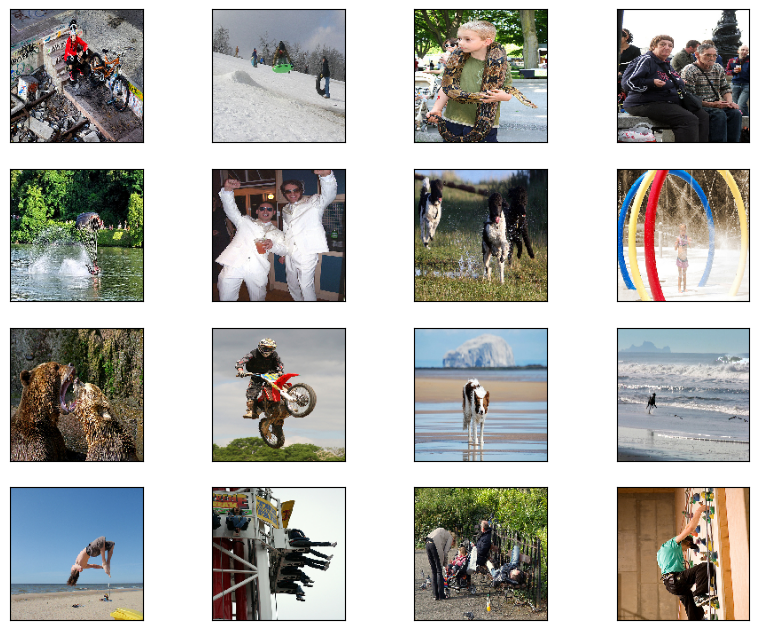

In [32]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

**Векторизация изображений**

Для векторизации изображений используем сеть ResNet50:

In [33]:
def create_model(input_shape):
    '''функция модели векторизации изображений'''
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
   
    model = Sequential()
    optimizer = Adam(learning_rate=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [34]:
input_shape = (150, 150, 3)
model_picture_vector = create_model(input_shape)

In [35]:
vector_picture = model_picture_vector.predict(train_datagen_flow)

2216/2216 [==============================] - 423s 191ms/step


In [36]:
vector_picture.shape

(35453, 2048)

## Векторизация текстов
<a id="section_5"></a>

**Векторизация текста описаний**

Векторизацию производим с помощью BERT. Загружаем модель "bert-base-uncased" (обученную на данных без учета регистра) и инициализируем автотокенизатор:

In [37]:
model = ppb.AutoModel.from_pretrained('bert-base-uncased')
tokenizer = ppb.AutoTokenizer.from_pretrained('bert-base-uncased')

In [38]:
def text_vectorization(df):
    '''функция векторизации текста описаний'''
    
    tokenized = df['query_text'].apply(
        lambda x: tokenizer.encode(x, padding=True, truncation=True, max_length=50, add_special_tokens = True))

    max_len = 0
    for i in tokenized.values:                                                  # определяем максимальную длину признака
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])   # увеличиваем длину признаков до максимальной

    attention_mask = np.where(padded != 0, 1, 0)                                # указываем нулевые и не нулевые значения   

    batch_size = 64                                                                            # размер батча
    embeddings = []                                                                            # список для векторов признаков
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):                              # выделяем батчи из выборки
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])                        # преобразовываем данные в формат тензоров
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) # преобразовываем данные в формат тензоров
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)                   # получаем эмбеддинги для батча
        embeddings.append(batch_embeddings[0][:,0,:].detach().numpy())                         # добавляем батчи в список
        i_last = i                                                                             # индекс последней строки батча
    # обработка остатка, не попавшего в цикл
    batch = torch.LongTensor(padded[batch_size*(i_last+1):df.shape[0]])                        # преобразовываем данные в формат тензоров
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*(i_last+1):df.shape[0]]) # преобразовываем данные в формат тензоров
    batch_embeddings = model(batch, attention_mask=attention_mask_batch)                       # получаем эмбеддинги для батча
    embeddings.append(batch_embeddings[0][:,0,:].detach().numpy())                             # добавляем батчи в список
    vector_text = np.concatenate(embeddings)                                                   # объединяем эмбеддинги
    vector_text = pd.DataFrame(vector_text)                                                    # создаем датафрейм
    return vector_text

In [39]:
vector_text = text_vectorization(df_train)

  0%|          | 0/553 [00:00<?, ?it/s]

In [40]:
vector_text.shape

(35453, 768)

## Объединение векторов
<a id="section_6"></a>

Объединяем векторы изображений и описаний:

In [41]:
X = np.concatenate((vector_picture, vector_text), axis=1)
print('Размер датафрейма признаков обучающей выборки: {}'.format(X.shape))

Размер датафрейма признаков обучающей выборки: (35453, 2816)


Выделяем целевой признак:

In [42]:
y = np.array(df_train['total_eval'])
print('Размер серии целевого признака обучающей выборки: {}'.format(y.shape))

Размер серии целевого признака обучающей выборки: (35453,)


**Вывод:**  
1. Обработаны описания с запрещенными словами.
2. Проведена векторизация текста описаний с помощью BERT.
3. Проведена векторизация изображений с помощью сети ResNet50.
4. Итоговые признаки отмасштабированы.

## Обучение модели предсказания соответствия
<a id="section_7"></a>

Обучим модели LinearRegression и полносвязную нейросеть NeuralNetwork.   
В качестве функции потерь используем MSE, метрики качества - MAE.  
Во избежание попадания одних и тех же изображений в обучающую и валидационную выборки разделяем их с помощью GroupShuffleSplit.

In [43]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=SEED)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [44]:
X_train, X_valid = X[train_indices], X[test_indices]

In [45]:
y_train, y_valid = y[train_indices], y[test_indices]

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [47]:
def metrics(model):
    pred = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, pred)
    pred_valid = model.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, pred_valid)
    return mae_train, mae_valid

### LinearRegression
<a id="section_7_1"></a>

Обучаем модель:

In [48]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
mae_lr_train, mae_lr = metrics(model_lr)
print('MAE на обучающей выборке: {:.6f}'.format(mae_lr_train))
print('MAE на валидационной выборке: {:.6f}'.format(mae_lr))

MAE на обучающей выборке: 0.154208
MAE на валидационной выборке: 0.158756


### NeuralNetwork
<a id="section_7_2"></a>

Создаем полносвязную сеть:

In [49]:
model_net = Sequential()
model_net.add(Dense(2816, input_shape=(2816,), activation='relu'))
model_net.add(BatchNormalization())
model_net.add(Dense(64, activation='relu'))
model_net.add(BatchNormalization())
model_net.add(Dense(16, activation='relu'))
model_net.add(BatchNormalization())
model_net.add(Dense(1))
    
optimizer = Adam(learning_rate=1e-3)
model_net.compile(optimizer=optimizer, loss='mean_squared_error',
        metrics='mae')

Создаем и обучаем модель:

In [50]:
model_net.fit(X_train, y_train, batch_size=32, epochs=15, verbose=False, shuffle=True)
mae_net_train, mae_net = metrics(model_net)
print('MAE на обучающей выборке: {:.6f}'.format(mae_net_train))
print('MAE на валидационной выборке: {:.6f}'.format(mae_net))



338/338 [==============================] - 1s 2ms/step
MAE на обучающей выборке: 0.139450
MAE на валидационной выборке: 0.158645


### Сводная таблица
<a id="section_7_3"></a>

In [51]:
df_model = pd.DataFrame({'model_name' : ['LinearRegression', 'NeuralNetwork'],
                         'mae' : [mae_lr, mae_net],
                         'model' : [model_lr, model_net]})
df_model[['model_name', 'mae']]                # выводим таблицу

model_name       mae
0  LinearRegression  0.158756
1     NeuralNetwork  0.158645

Выбираем модель с наименьшим MAE:

In [52]:
best_model_row = df_model.loc[df_model['mae'] == df_model['mae'].min()]
best_model = best_model_row.iloc[0, 2]

In [53]:
print('Лучшая модель - {}'.format(best_model_row.iloc[0, 0]))
print('MAE лучшей модели - {:.6f}'.format(best_model_row.iloc[0, 1]))

Лучшая модель - NeuralNetwork
MAE лучшей модели - 0.158645


## Тестирование модели
<a id="section_8"></a>

Объединяем датафрейм, содержащий данные по тестовым изображениям, и датафрейм с описаниями к изображениям:

In [54]:
df_test = pd.merge(df_test_img, df_test_queries, how='inner', on='image').dropna()

Помечаем наблюдения, в описании которых присутствуют запрещенные слова:

In [55]:
df_test['stop_word'] = df_test.apply(lambda x: text_modify(x['query_text']), axis=1)

Загружаем тестовые изображения:

In [56]:
def load_test(df) -> ImageDataGenerator:  
    '''загрузчик данных для тестирования''' 
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='test_images',
        x_col='image',
        y_col='query_text',
        target_size=(150, 150),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

In [57]:
test_datagen_flow = load_test(df_test)

Found 500 validated image filenames.


In [58]:
def test_preprocessing(df_test):
    vector_picture_test = model_picture_vector.predict(test_datagen_flow)             # векторезируем тестовые изображения
    vector_text_test = text_vectorization(df_test_queries)                            # векторезируем тестовые описания
    X_test = np.concatenate((vector_picture_test, vector_text_test), axis=1)          # объединяем полученные признаки
    X_test = scaler.transform(X_test)                                                 # масштабируем признаки
    pred_test = best_model.predict(X_test)                                            # получаем предсказания
    # добавляем предсказания в датафрейс с данными по тестовой выборке
    df_test = pd.concat((df_test, pd.Series(np.reshape(pred_test, (pred_test.shape[0],)), name='predict')), axis=1)
    # Собираем датафрейм с лучшими предсказаниями для каждого изображения
    df_best_score = (
    df_test
    .sort_values(['image', 'predict'], ascending=False)
    .groupby('image').first()
    .reset_index()
    )
    return df_best_score

In [59]:
df_best_score = test_preprocessing(df_test)

32/32 [==============================] - 7s 182ms/step


  0%|          | 0/7 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


Выводим тестовые изображения с соответствующими описаниями:

In [60]:
def plotter(df):
    for i in range(df.shape[0]):
        if df.iloc[i][3] == 1:
            print('Описание: {}'.format(df.iloc[i][2]))
            print('This image is unavailable in your country in compliance with local laws')
            print('_'*50)
            print()
        else:
            fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
            plt.rcParams['axes.edgecolor'] = 'black'
            plt.rcParams['axes.linewidth'] = 0
            image = Image.open(Path('test_images', df.iloc[i][0]))
            plt.title('Описание: {}'.format(df.iloc[i][2]))
            plt.imshow(image)
    return None

In [61]:
df_best_score_random = df_best_score.sample(n = 10, random_state = 0)

Описание: Middle school aged kids are showing their school spirit at a pep ralley .
This image is unavailable in your country in compliance with local laws
__________________________________________________

Описание: a group of teenagers standing outside of a convienance store .
This image is unavailable in your country in compliance with local laws
__________________________________________________

Описание: A child in a green shirt balancing on a red rope while holding two white ropes .
This image is unavailable in your country in compliance with local laws
__________________________________________________



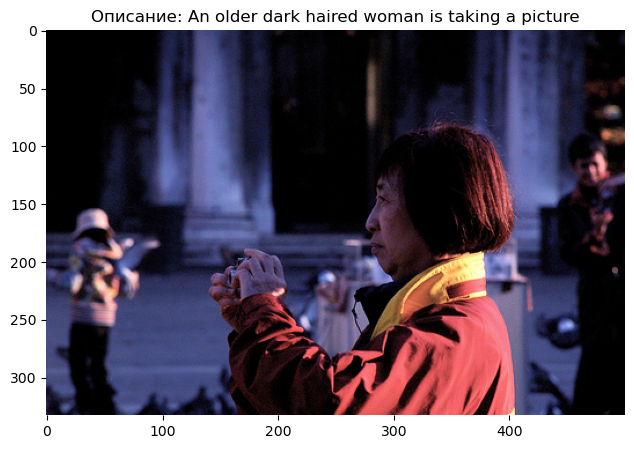

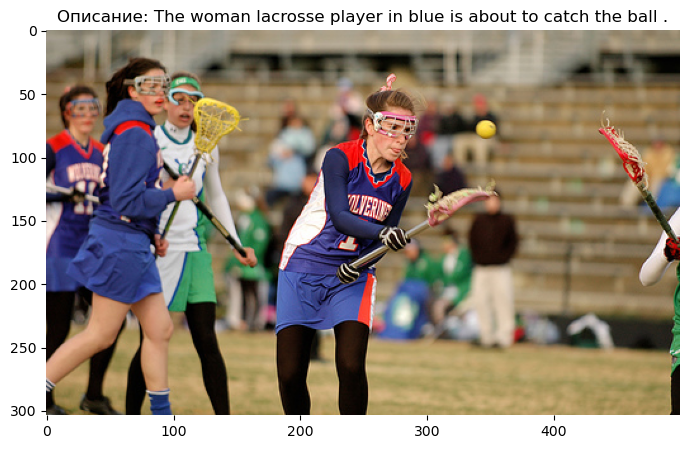

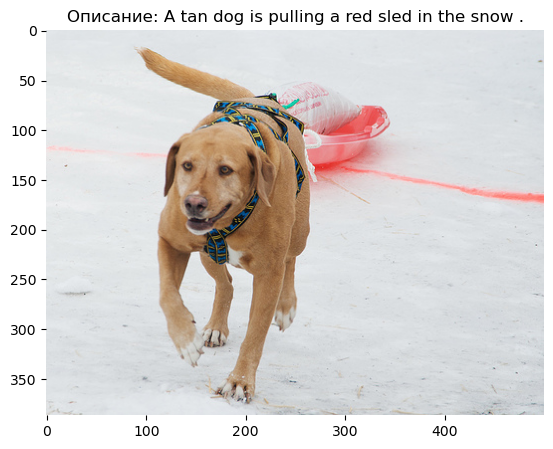

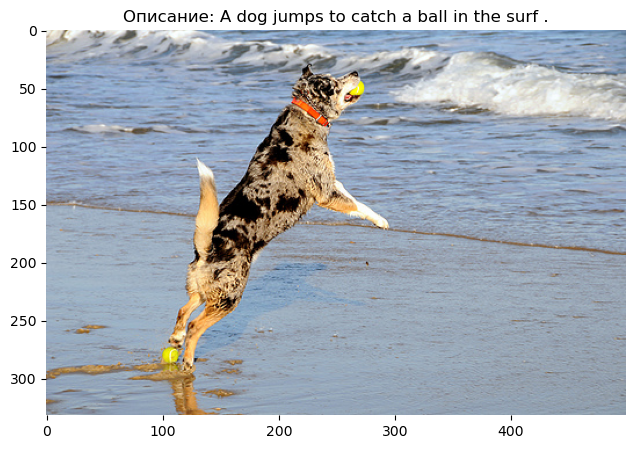

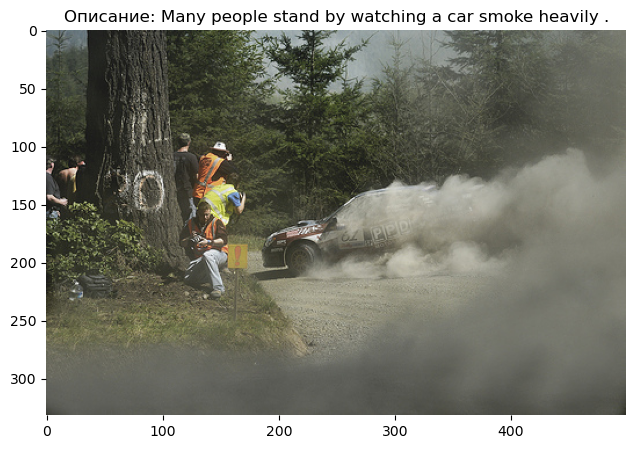

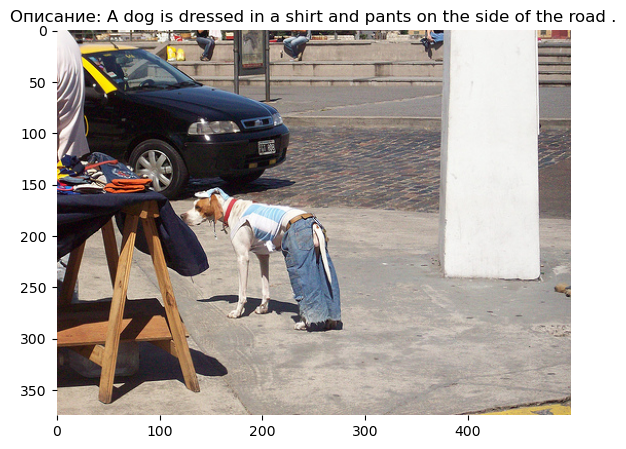

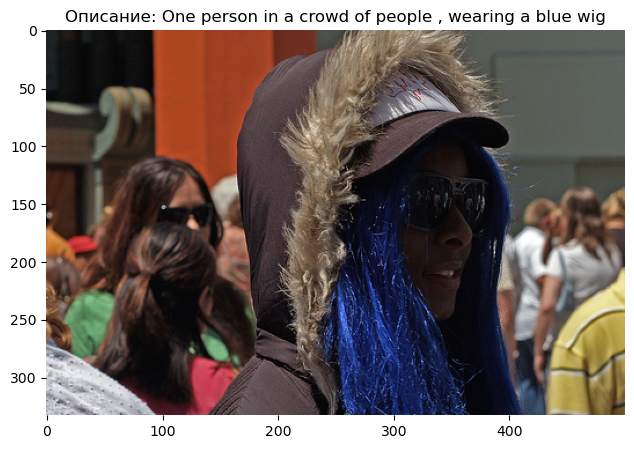

In [62]:
plotter(df_best_score_random)

**Вывод:**  
Полученная модель обеспечивает высокое качество подбора изображений по описанию.

## Общий вывод
<a id="section_9"></a>

**Исследовательский анализ**  

1. Размеры датафреймов:
 - df_test_img - 100 строк;
 - df_test_queries - 500 строк;
 - df_train - 5822 строк;
 - df_crowd - 47830 строк;
 - df_expert - 5822 строк;
2. Пропуски отсутствуют.
3. Количество уникальных изображений:
 - в обучающей выборке - 1000;
 - в тестовой выборке - 100.
4. Количество уникальных описаний:
 - в обучающей выборке - 977;
 - в тестовой выборке - 500;
5. Изображения, входящие как в обучающую, так и тестовую выборки отсутствуют.
6. Описания, входящие как в обучающую, так и тестовую выборки отсутствуют.


**Подготовка данных к обучению**
 
1. Обработаны описания с запрещенными словами.
2. Проведена векторизация текста описаний с помощью BERT.
3. Проведена векторизация изображений с помощью сети ResNet50.
4. Итоговые признаки отмасштабированы.  

**Тестирование модели**  

Описание: Middle school aged kids are showing their school spirit at a pep ralley .
This image is unavailable in your country in compliance with local laws
__________________________________________________

Описание: a group of teenagers standing outside of a convienance store .
This image is unavailable in your country in compliance with local laws
__________________________________________________

Описание: A child in a green shirt balancing on a red rope while holding two white ropes .
This image is unavailable in your country in compliance with local laws
__________________________________________________



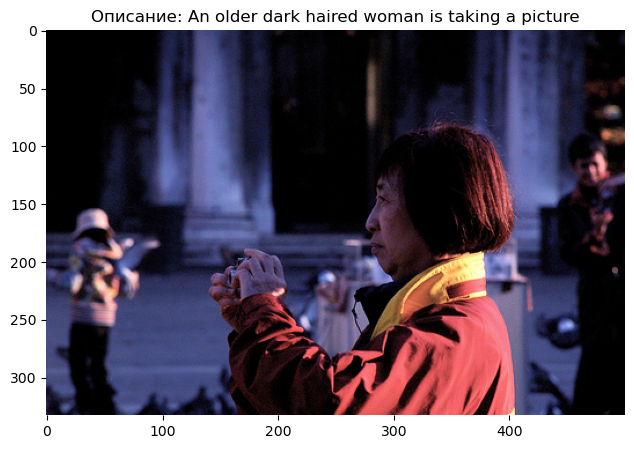

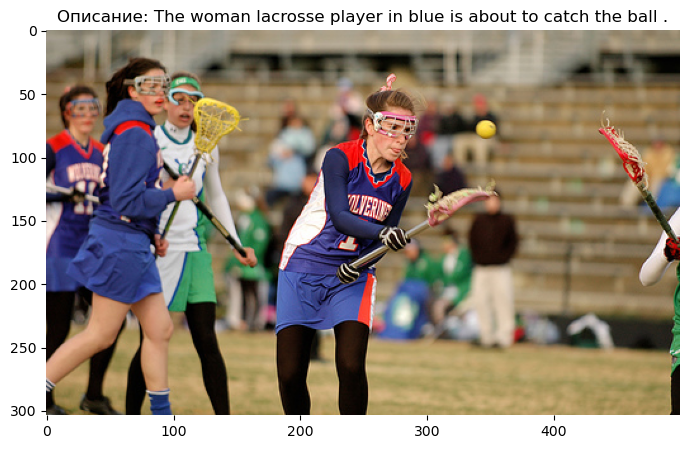

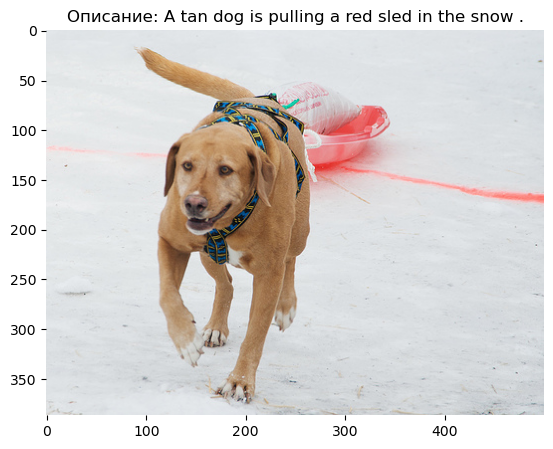

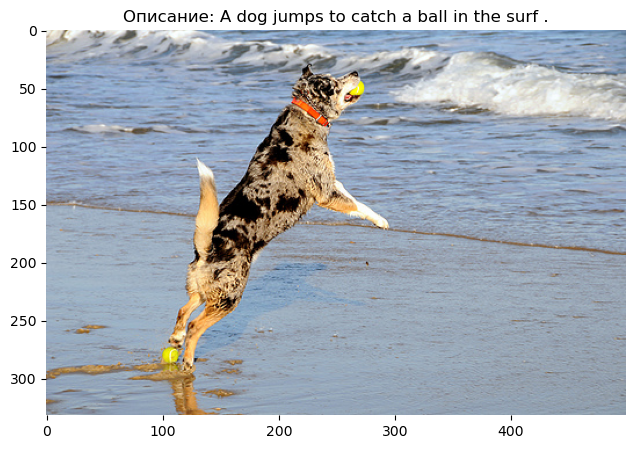

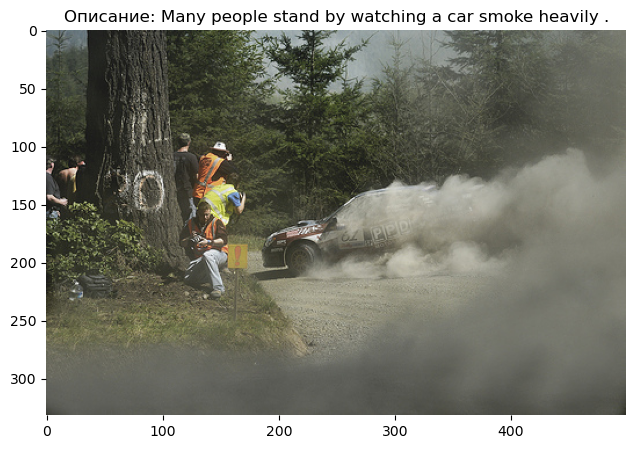

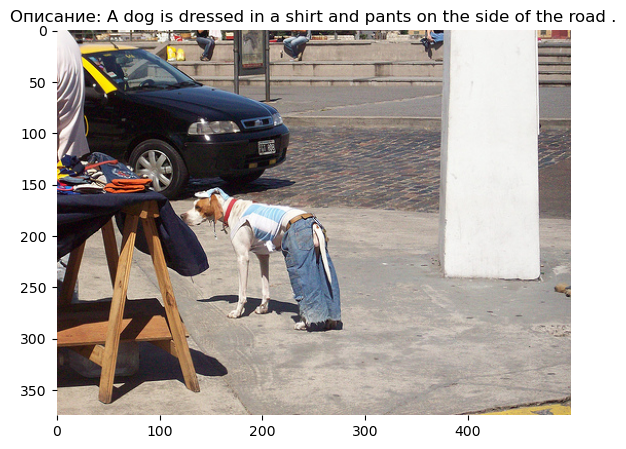

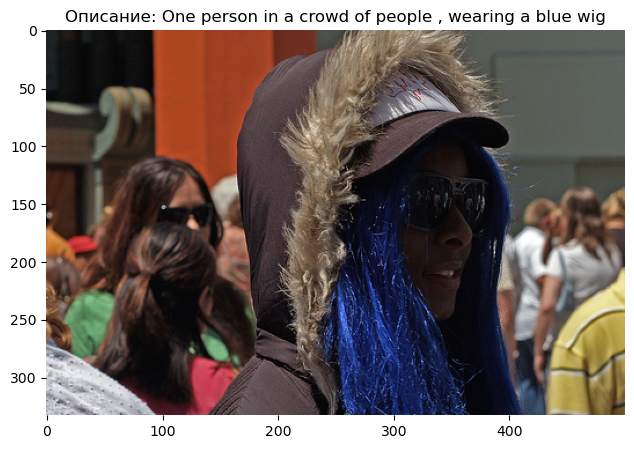

In [63]:
plotter(df_best_score_random)